# Практическая работа №1
## Предварительная обработка данных
Выполнил: Терентьев Никита Александрович КИ21-16/1б
Вариант: 21
## Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных, формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
## Задачи
Выполнение практической работы предполагает решение следующих задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных
## Ход работы
Был произведён импорт необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import sklearn.impute

from scipy.stats import sigmaclip
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

from draw_functions import build_bar_and_pie_chart, build_histogram_density_diagram

Произведено чтение файла и взятие нужных колонок из таблицы в соответствии с вариантом.

In [2]:
dataframe = pd.read_excel(r"C:\Users\nikit\Desktop\Программирование\4 семестр\data_analysis_methods\1 lab\data\first_practice_dataframe.xlsx")
# Названия колонок датафрейма храним в константах
qualitative_variables = ["cat1_gender", "cat3_education"]
quantitative_variables = ["num1_22", "num2_22", "num3_22"]
dataframe = dataframe[[*qualitative_variables, *quantitative_variables]]
initial_dataframe = dataframe.copy()
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22
0,male,high school,311.628509,664.606363,648.5319
1,male,phd,88.551646,1001.232482,665.864398
2,male,School SAT,314.105165,806.071418,667.958668
3,NaN,BSc,-168.550590,987.065373,651.231183
4,male,phd,294.298042,1216.844021,645.612568
...,...,...,...,...,...
995,male,phd,-34.721255,NaN,619.945966
996,male,phd,-55.516395,858.140616,637.922461
997,male,phd,-43.164240,717.465601,675.80899
998,NaN,phd,-220.999640,1001.632875,NaN


Выведем типы данных в нашем датафрейме.

In [3]:
dataframe.dtypes

cat1_gender        object
cat3_education     object
num1_22           float64
num2_22           float64
num3_22            object
dtype: object

### 1. Визуальный анализ данных
Были построены графики для визуального представления каждого столбца(признака) в исходном наборе данных.
Все функции для построения графиков были вынесены в отдельный файл functions.py

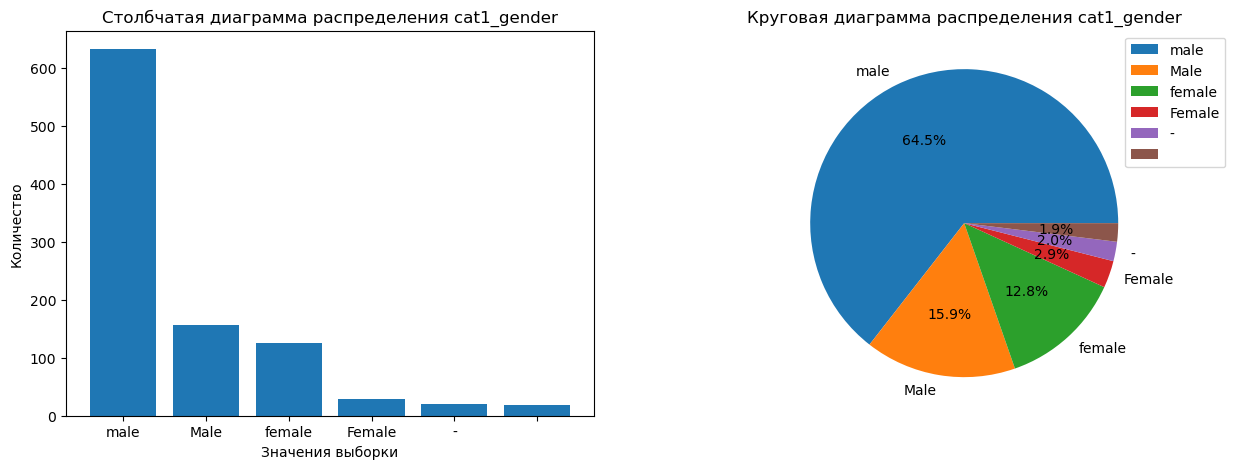

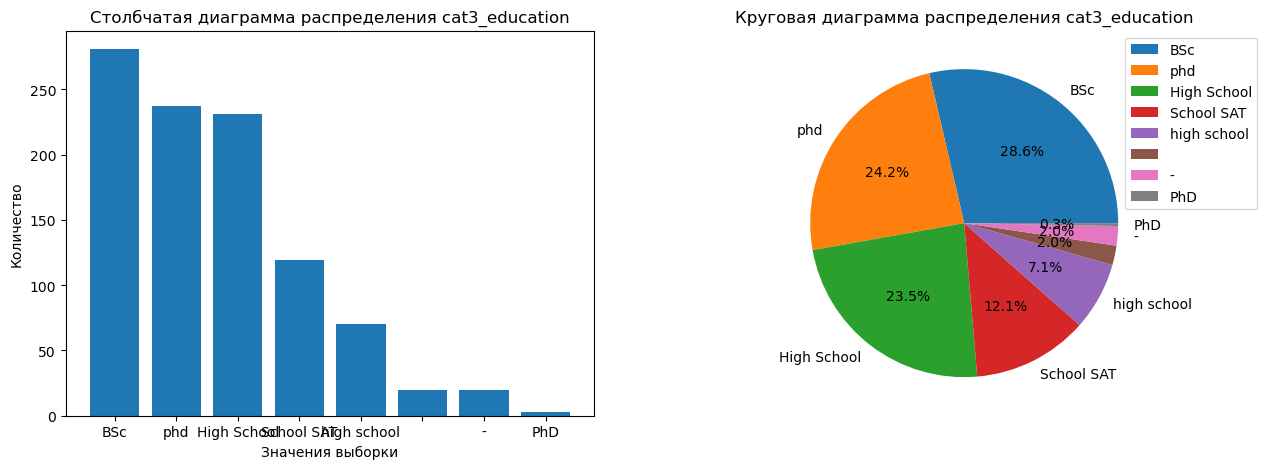

In [4]:
for column in qualitative_variables:
    build_bar_and_pie_chart(dataframe[column], column)

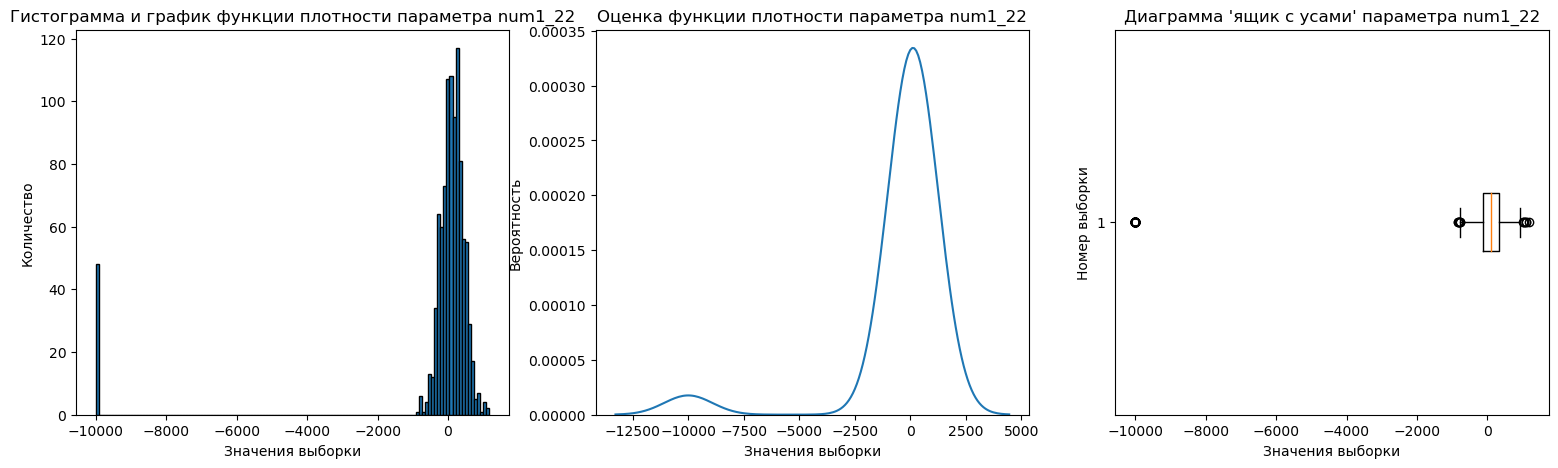

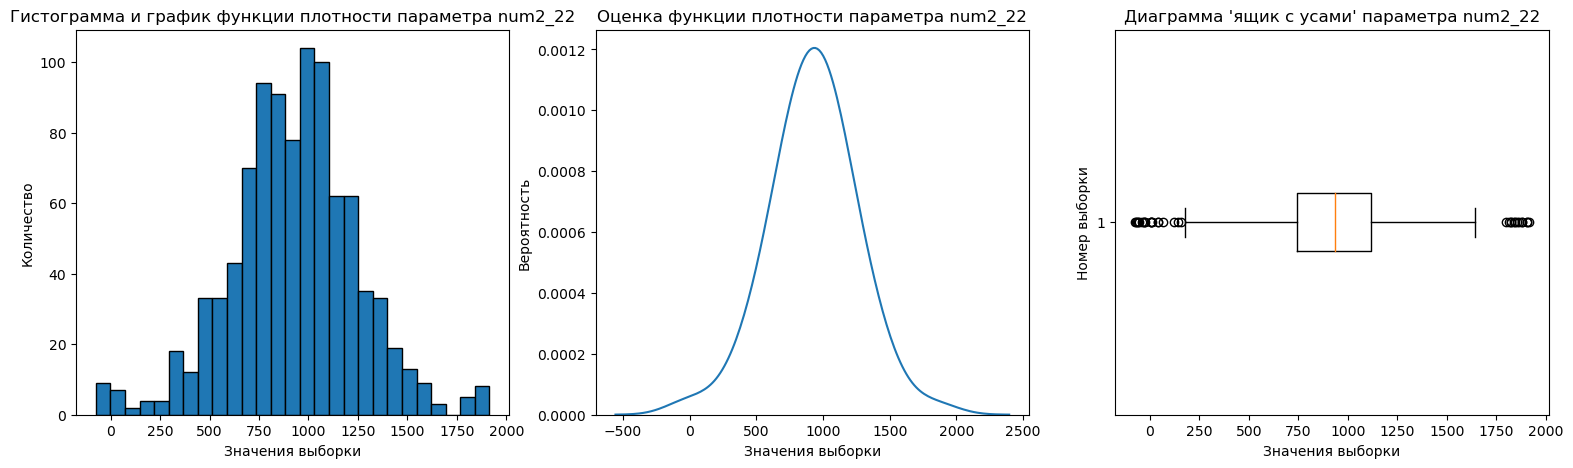

График признака num3_22 не может быть построен, так как столбец содержит не только числовые значения.


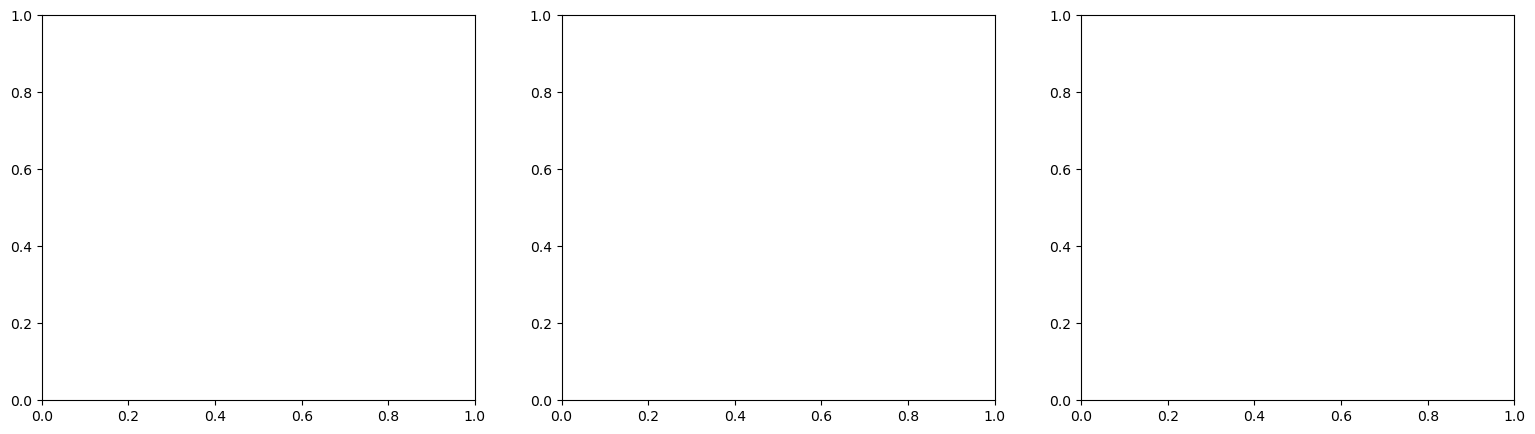

In [5]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

### 2. Проверка правдоподобности исходных данных
Проанализировав полученные графики, можно сделать вывод, что некоторые значения из таблицы являются некорректными (например, пропуски значений).

#### Приведение значений качественных признаков
Приведём значения качественных признаков к нужному формату (всем пустым значениям был присвоен тип None, признаки, отличающиеся типом написания, были приведены к одному виду). Также первая и вторая колонка были приведены к категориальному типу.

In [6]:
for column in qualitative_variables:
    dataframe[column].replace({" ": None, "-": None, np.nan: None}, inplace=True)
    dataframe[column] = dataframe[column].apply(lambda x: x.capitalize() if isinstance(x, str) else x)
    dataframe[column] = dataframe[column].astype("category")

#### Приведение значений количественных признаков

In [7]:
for column in quantitative_variables:
    # Если errors='coerce', то недопустимый синтаксический анализ будет установлен как NaN.
    dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')

In [8]:
dataframe.dtypes

cat1_gender       category
cat3_education    category
num1_22            float64
num2_22            float64
num3_22            float64
dtype: object

Выведем ещё раз все графики.

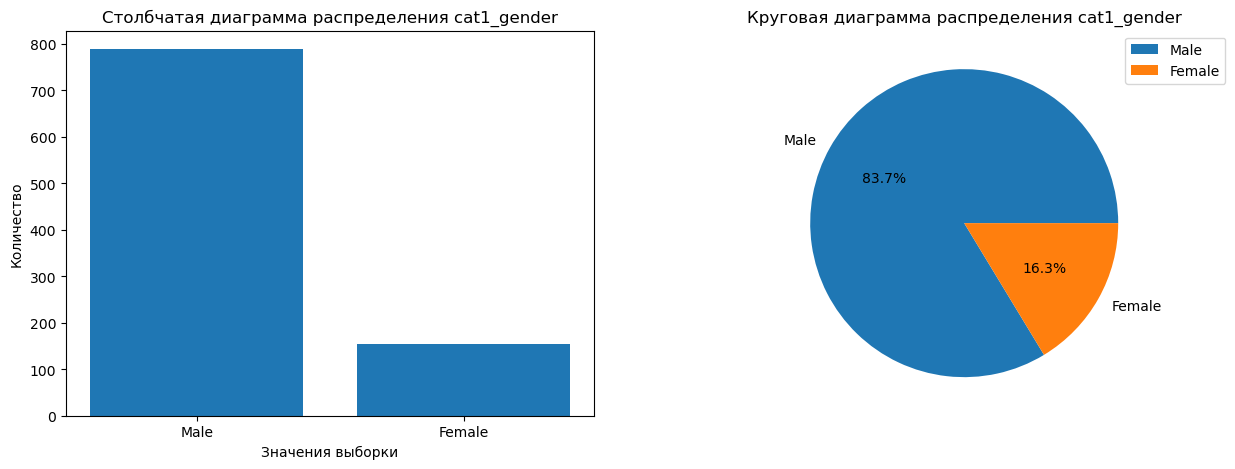

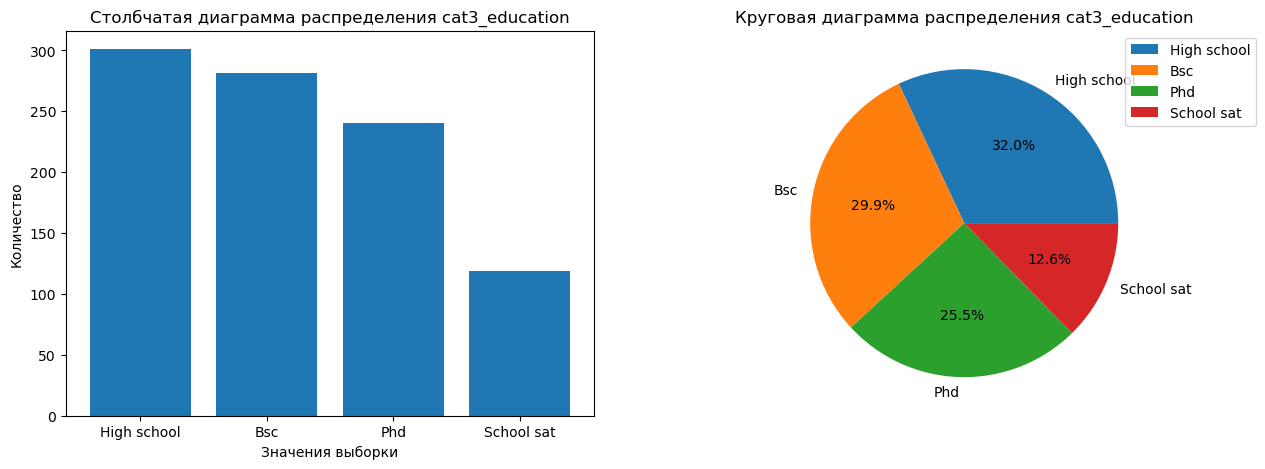

In [9]:
for column in qualitative_variables:
    build_bar_and_pie_chart(dataframe[column], column)

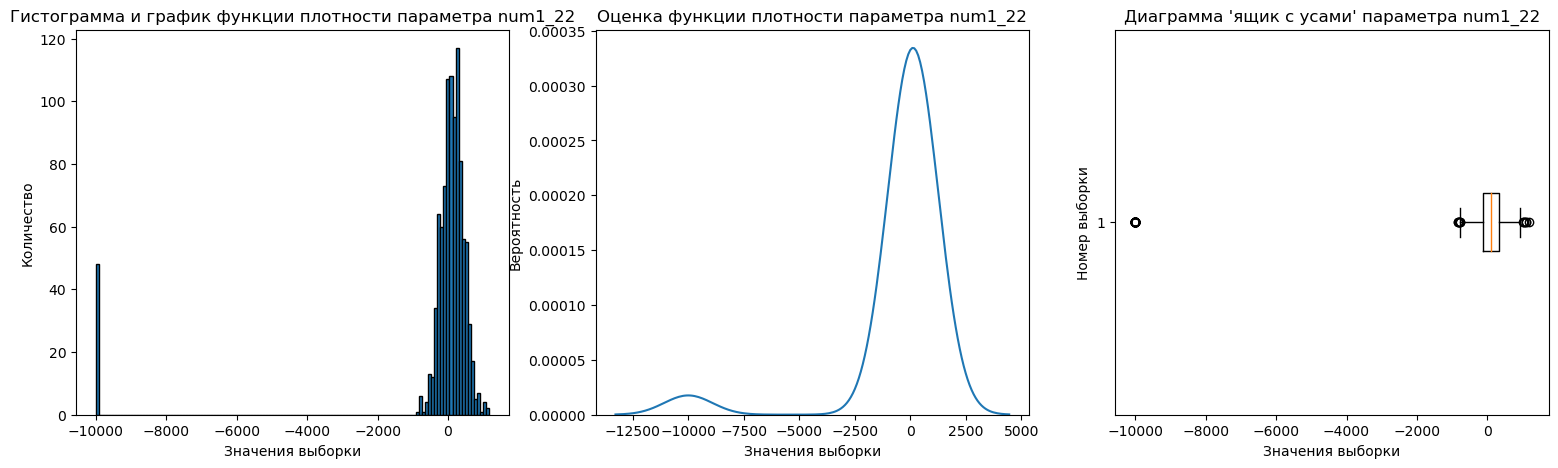

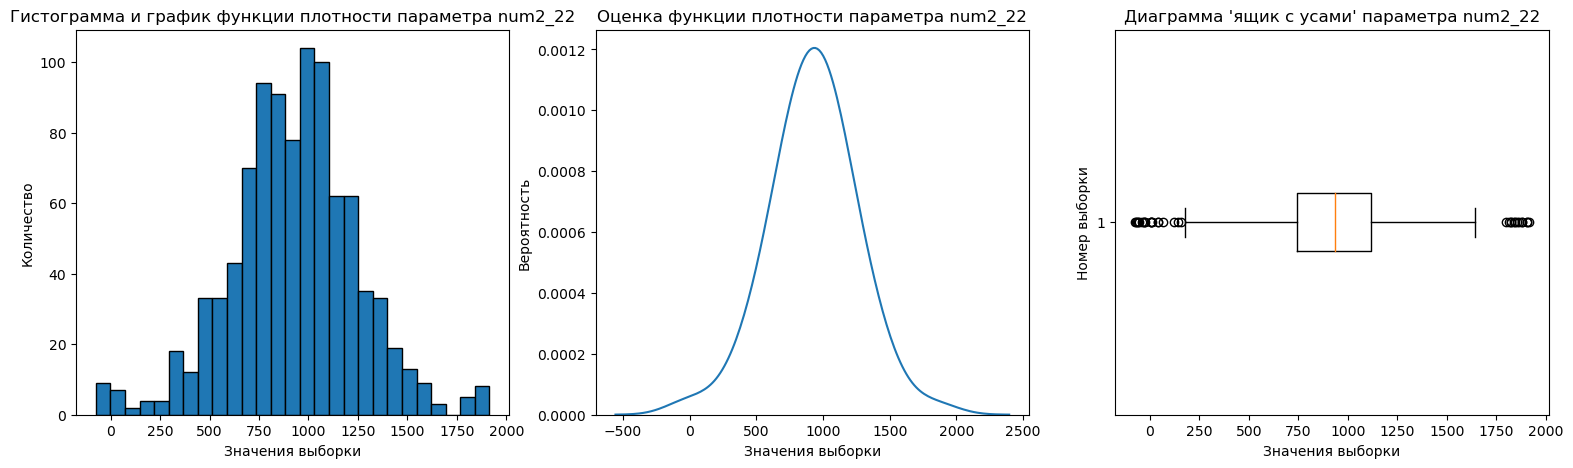

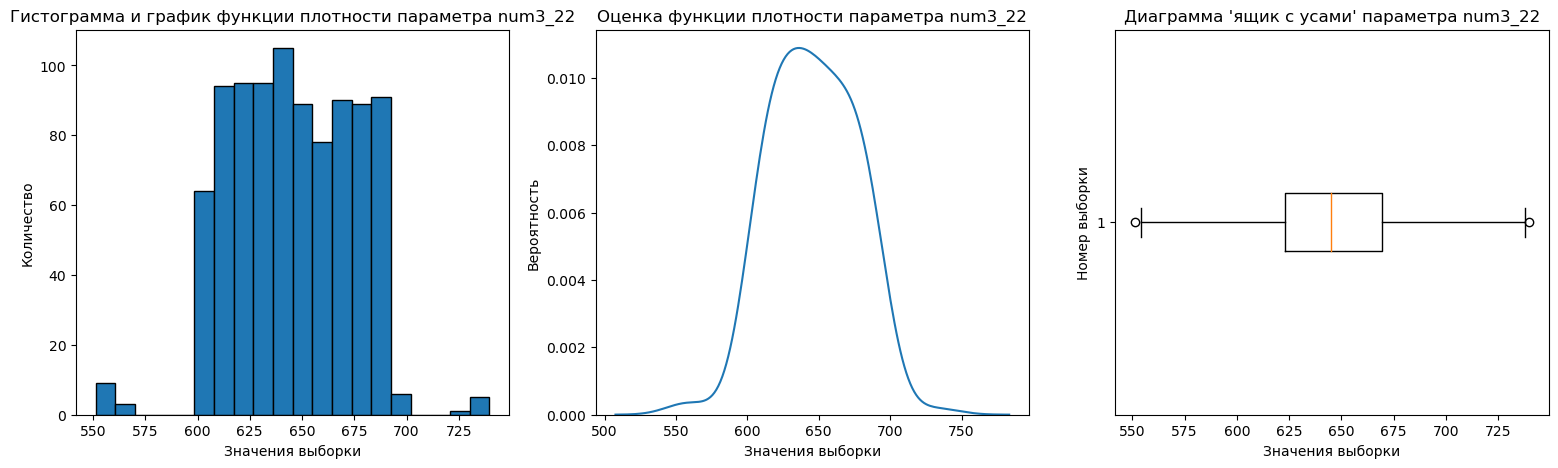

In [10]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

Все данные были приведены к нужному формату. Все качественные признаки имеют тип category, все количественные - float64.

### 3. Поиск аномальных значений
Было произведено копирование датафрейма.

In [11]:
dataframe_copy = dataframe.copy()
dataframe_sigma = dataframe.copy()
dataframe_quantile = dataframe.copy()

#### Метод сигм
Выведем изначальное количество значений

In [12]:
for column in quantitative_variables:
    print(f"Количество не пустых значений в параметре {column}: {dataframe_sigma[column].count()}")

Количество не пустых значений в параметре num1_22: 1000
Количество не пустых значений в параметре num2_22: 951
Количество не пустых значений в параметре num3_22: 914


In [13]:
def sigma_method(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Удаляет выбросы из числовых столбцов фрейма данных, используя метод сигма.
    :param dataframe: Датафрейм
    :return: Датафрейм после удаления выбросов.
    """
    numerical_columns = dataframe.select_dtypes(include=['float']).columns
    for column in numerical_columns:
        data = dataframe[column].dropna()
        clean_data, low, high = sigmaclip(data, low=3, high=3)
        dataframe = dataframe.loc[dataframe.loc[:, column].isin(clean_data) | dataframe.loc[:, column].isna()]
    return dataframe.loc[dataframe.loc[:, numerical_columns[0]].notna()]

dataframe_sigma = sigma_method(dataframe_sigma)

Выведем количество значений после удаления выбросов c помощью метода сигм.

In [14]:
for column in quantitative_variables:
    print(f"Количество не пустых значений в параметре {column}: {dataframe_sigma[column].count()}")

Количество не пустых значений в параметре num1_22: 893
Количество не пустых значений в параметре num2_22: 849
Количество не пустых значений в параметре num3_22: 814


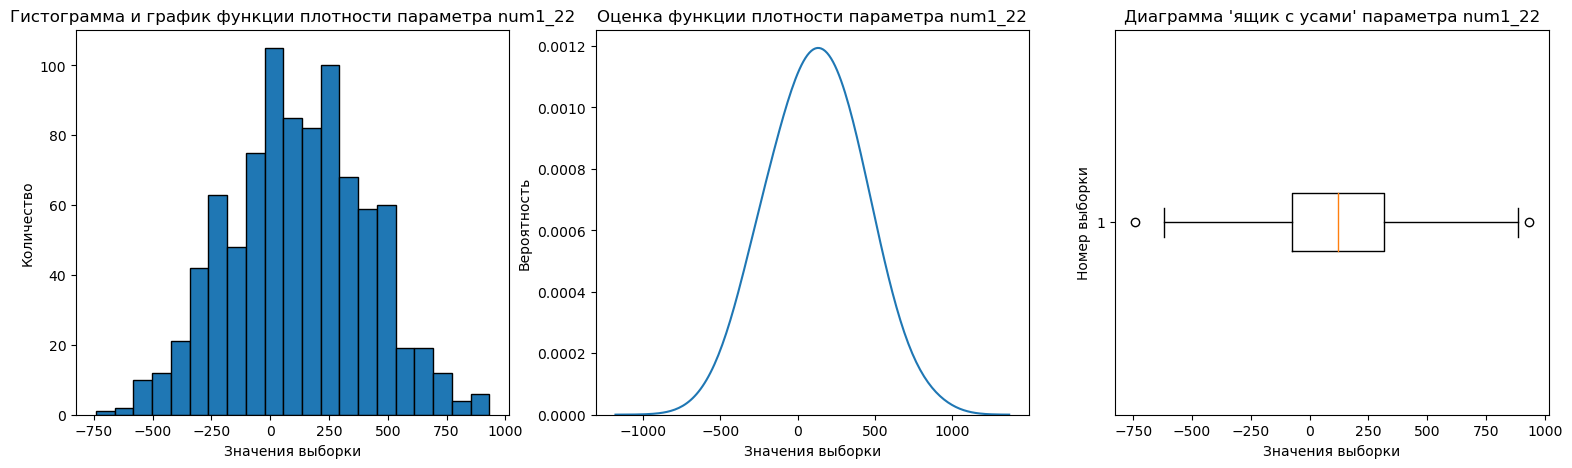

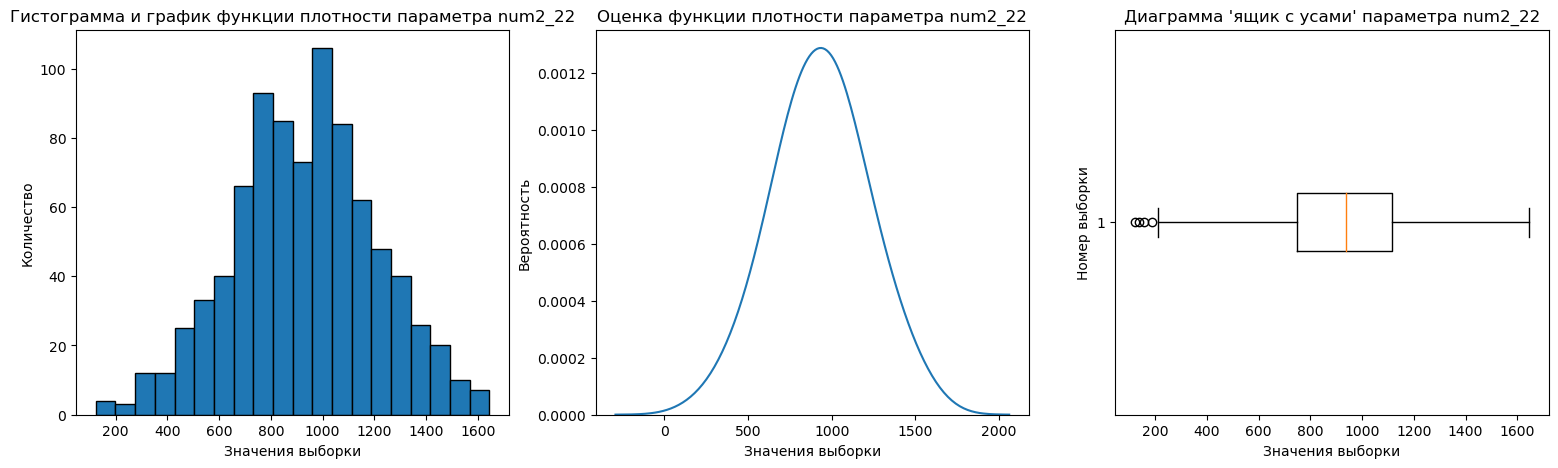

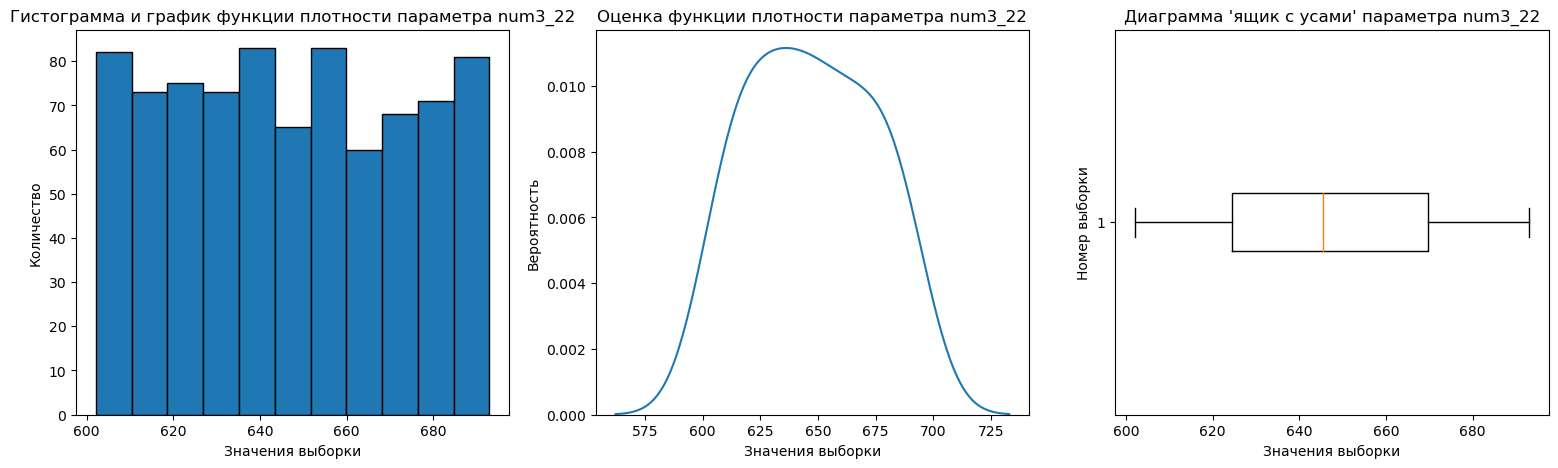

In [15]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe_sigma[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

#### Метод квантилей

In [16]:
def quantile_method(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Метод квантилей
    :param dataframe: Датафрейм
    :return: измененный Датафрейм с удалёнными выбросами
    """
    num_colums = dataframe.select_dtypes(include=['float']).columns
    q25 = dataframe[num_colums].quantile(0.25)
    q75 = dataframe[num_colums].quantile(0.75)
    delta = q75 - q25
    low = q25 - 1.5 * delta
    high = q75 + 1.5 * delta
    filtered_dataframe = dataframe[
        ~((dataframe[num_colums] < low) | (dataframe[num_colums] > high)).any(axis=1)]
    filtered_dataframe = filtered_dataframe.reset_index(drop=True)
    return filtered_dataframe

dataframe_quantile = quantile_method(dataframe_quantile)

In [17]:
for column in quantitative_variables:
    print(f"Количество не пустых значений в параметре {column}: {dataframe_quantile[column].count()}")

Количество не пустых значений в параметре num1_22: 907
Количество не пустых значений в параметре num2_22: 862
Количество не пустых значений в параметре num3_22: 827


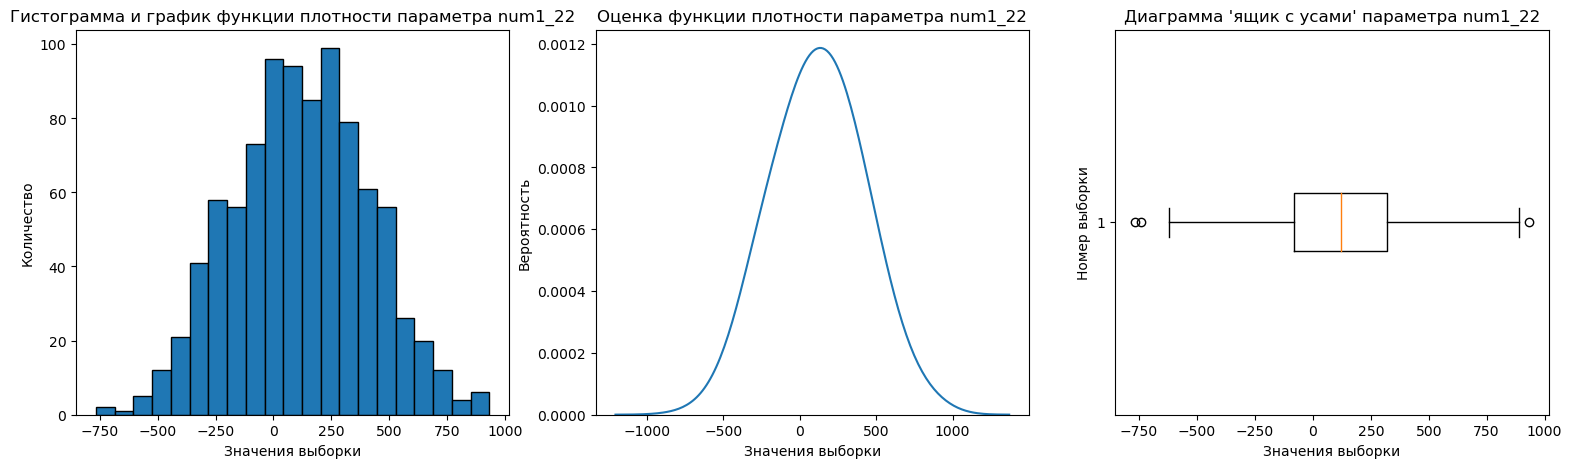

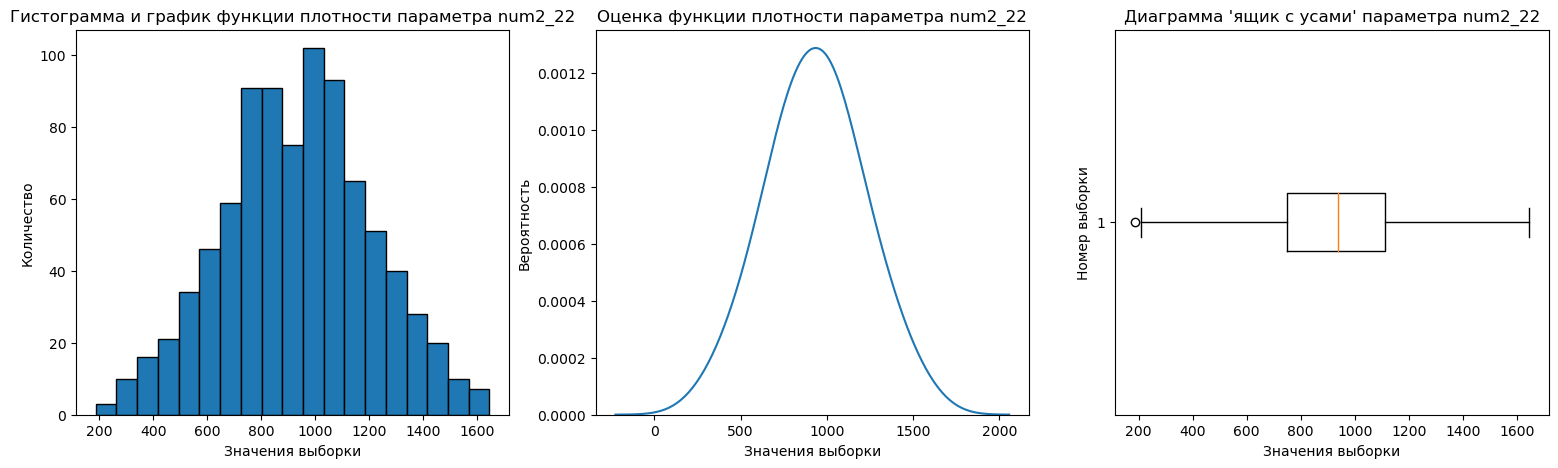

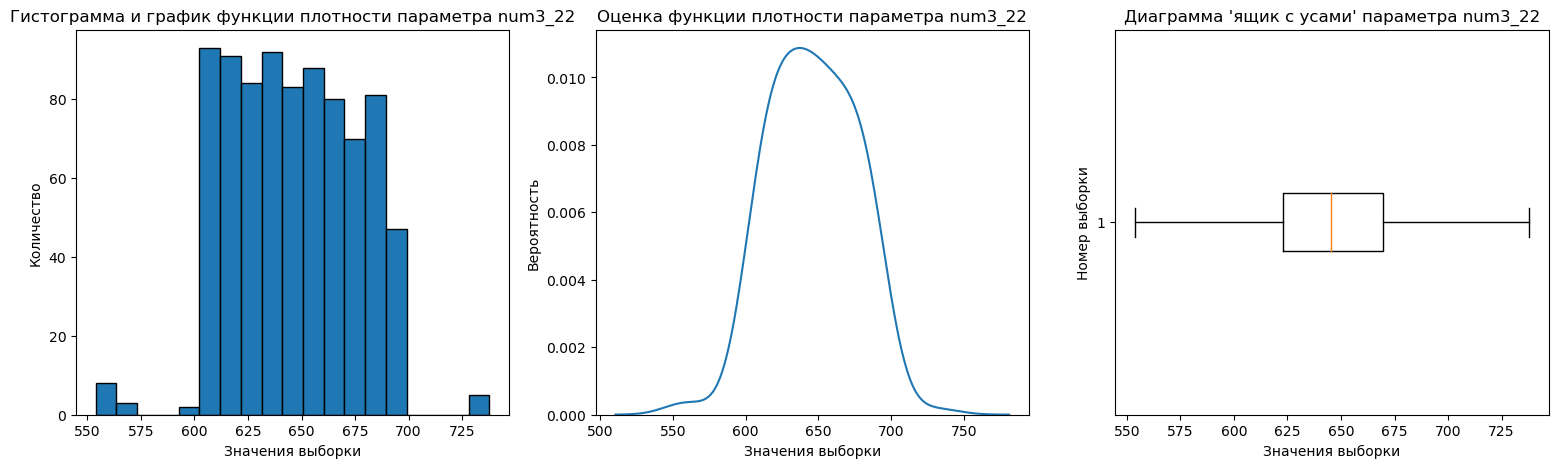

In [18]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe_quantile[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

Используем результаты очистки данных, полученных с помощью метода сигм.

In [19]:
dataframe = dataframe_sigma

### 4. Поиск и восстановление пропущенных значений
Узнаем количество пропущенных значений в нашем датафрейме.

In [20]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 0 to 998
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   cat1_gender     839 non-null    category
 1   cat3_education  840 non-null    category
 2   num1_22         893 non-null    float64 
 3   num2_22         849 non-null    float64 
 4   num3_22         814 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 30.0 KB


Всего в датафрейме 893 строки, в 3 столбце столько же значений, следовательно, в нём не надо восстанавливать пропущенные значения. Пропуски значений первого столбца будут заменены значениями, полученными с помощью метода “k-ближайших соседей”.

In [21]:
first_column = qualitative_variables[0]

dataframe_filled = dataframe.copy()

nan_index = dataframe_filled[first_column][dataframe_filled[first_column].isna()].index[0]
imputer = sklearn.impute.KNNImputer(n_neighbors=5)
encoder = LabelEncoder()
dataframe_filled[first_column] = encoder.fit_transform(dataframe_filled[first_column])
dataframe_filled[first_column] = dataframe_filled[first_column].replace({dataframe_filled[first_column][nan_index]: np.nan})
dataframe_filled[first_column] = imputer.fit_transform(dataframe_filled[[first_column]])
dataframe_filled[first_column] = dataframe_filled[first_column].apply(lambda x: round(x))
dataframe_filled[first_column] = encoder.inverse_transform(dataframe_filled[first_column])
dataframe = dataframe_filled
print(f'Есть ли nan элементы: {dataframe[first_column].isna().any()}')

Есть ли nan элементы: False


Пропуски значений второго признака были заменены самым популярным значением.

In [22]:
second_column = qualitative_variables[1]
most_frequence = dataframe[second_column].value_counts().keys()[0]
dataframe[second_column] = dataframe[second_column].fillna(most_frequence)
print(f'Есть ли в столбце nan элементы: {dataframe[second_column].isna().any()}')

Есть ли в столбце nan элементы: False


Пропуски значений четвёртого признака были заменены медианой.

In [23]:
four_column = quantitative_variables[1]
median = dataframe[four_column].median()
dataframe[four_column] = dataframe[four_column].fillna(median)
print(f'Есть ли в столбце nan элементы: {dataframe[four_column].isna().any()}')

Есть ли в столбце nan элементы: False


Пропуски значений пятого признака были заменены значениями, полученными методом "k-ближайших соседей".

In [24]:
fifth_column = quantitative_variables[2]
knn_imputer = sklearn.impute.KNNImputer(n_neighbors=3)
# Заполняем пропущенные значения в выбранном столбце
dataframe[[fifth_column]] = knn_imputer.fit_transform(dataframe[[fifth_column]])
print(f'Есть ли в столбце nan элементы: {dataframe[fifth_column].isna().any()}')

Есть ли в столбце nan элементы: False


Все значения были восстановлены.

### 5. Преобразование данных
#### Кодировка категориальных признаков
Было выполнена кодировка первого категориального признака с помощью one-hot encoding.

In [25]:
onehot_encoder = OneHotEncoder(min_frequency=6, sparse_output=False, categories="auto")
dataframe_encoded = pd.DataFrame(onehot_encoder.fit_transform(dataframe[[qualitative_variables[0]]]), columns=onehot_encoder.get_feature_names_out())
dataframe = dataframe.join(dataframe_encoded)

Для второго категориального признака была произведена кодировка при помощи label encoding.

In [26]:
dataframe[qualitative_variables[1] + "lb"] = LabelEncoder().fit_transform(dataframe[qualitative_variables[1]])
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22,cat1_gender_Female,cat1_gender_Male,cat3_educationlb
0,Male,High school,311.628509,664.606363,648.531900,0.0,1.0,1
1,Male,Phd,88.551646,1001.232482,665.864398,0.0,1.0,2
2,Male,School sat,314.105165,806.071418,667.958668,0.0,1.0,3
3,Male,Bsc,-168.550590,987.065373,651.231183,0.0,1.0,0
4,Male,Phd,294.298042,1216.844021,645.612568,0.0,1.0,2
...,...,...,...,...,...,...,...,...
994,Male,School sat,3.329050,936.861148,649.647338,NaN,NaN,3
995,Male,Phd,-34.721255,936.861148,619.945966,NaN,NaN,2
996,Male,Phd,-55.516395,858.140616,637.922461,NaN,NaN,2
997,Male,Phd,-43.164240,717.465601,675.808990,NaN,NaN,2


#### Преобразование количественных признаков
В нормализованном наборе данных значения находятся между 0 и 1. Стандартизированный набор данных имеет нулевое среднее значение и единичную дисперсию (стандартное отклонение). Первый и второй количественный признак были приведены к нормализованному виду.

In [27]:
min_max_scaler = MinMaxScaler()
dataframe_scaled = pd.DataFrame(min_max_scaler.fit_transform(dataframe[quantitative_variables]), columns=quantitative_variables)
dataframe = pd.merge(dataframe, dataframe_scaled, left_index=True, right_index=True, suffixes=('', '_norm'))

Третий количественный признак был приведён к стандартизированному виду.

In [28]:
standart_scaler = StandardScaler()
dataframe_scaled = pd.DataFrame(standart_scaler.fit_transform(dataframe[quantitative_variables]), columns=quantitative_variables)
dataframe = pd.merge(dataframe, dataframe_scaled, left_index=True, right_index=True, suffixes=('', '_stand'))
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22,cat1_gender_Female,cat1_gender_Male,cat3_educationlb,num1_22_norm,num2_22_norm,num3_22_norm,num1_22_stand,num2_22_stand,num3_22_stand
0,Male,High school,311.628509,664.606363,648.531900,0.0,1.0,1,0.629187,0.355773,0.510758,0.626932,-1.014671,0.091860
1,Male,Phd,88.551646,1001.232482,665.864398,0.0,1.0,2,0.495883,0.577079,0.701484,-0.133093,0.240308,0.777854
2,Male,School sat,314.105165,806.071418,667.958668,0.0,1.0,3,0.630667,0.448775,0.724529,0.635370,-0.487274,0.860742
3,Male,Bsc,-168.550590,987.065373,651.231183,0.0,1.0,0,0.342247,0.567765,0.540460,-1.009042,0.187491,0.198694
4,Male,Phd,294.298042,1216.844021,645.612568,0.0,1.0,2,0.618831,0.718827,0.478633,0.567887,1.044131,-0.023682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,Male,Bsc,-293.664621,979.030474,653.803193,0.0,1.0,0,0.633876,0.457716,0.091518,0.653666,-0.436573,-1.416037
795,Male,Bsc,326.064158,804.113638,632.894762,0.0,1.0,0,0.729076,0.825355,0.666819,1.196443,1.648233,0.653173
796,Male,School sat,-295.555008,802.403066,646.968443,0.0,1.0,3,0.268176,0.437408,0.416680,-1.431349,-0.551734,-0.246512
797,Male,School sat,1.085027,922.165762,605.969800,1.0,0.0,3,0.297170,0.585973,0.329129,-1.266042,0.290744,-0.561410


## Выводы
В ходе работы были изучены основные задачи предварительной обработки исходных данных и методы предварительной обработки данных. Был произведён визуальный анализ исходных данных, поиск аномальных значений, восстановление отсутствующих значений и преобразование данных. Ниже произведено сравнение графиков, построенных по исходным данным и по полученным в результате работы обработанным данным.

Выведем итоговые графики

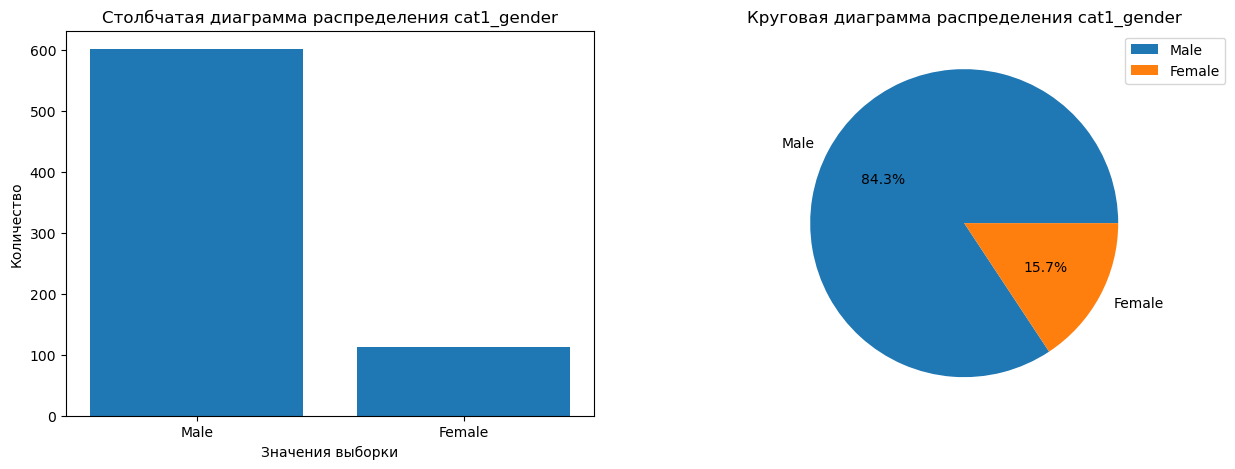

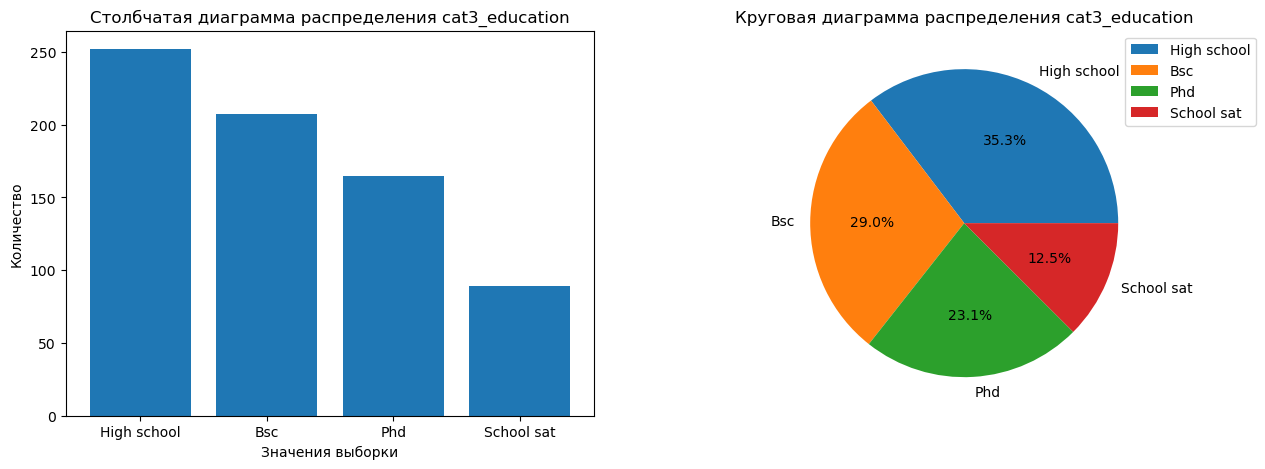

In [29]:
for column in qualitative_variables:
    build_bar_and_pie_chart(dataframe[column], column)

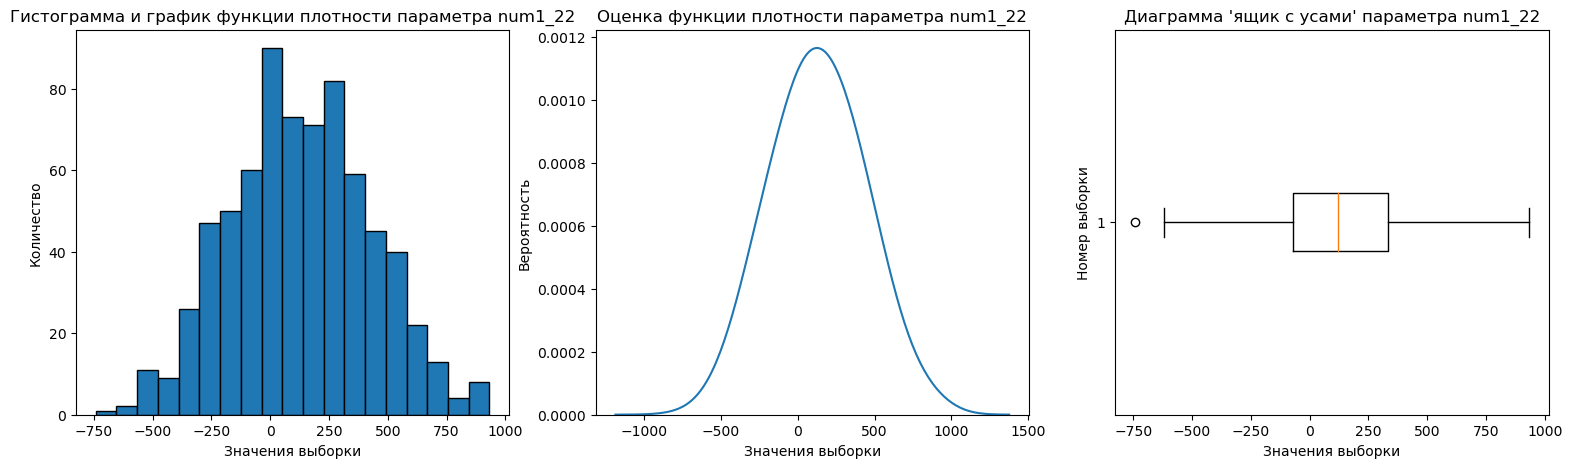

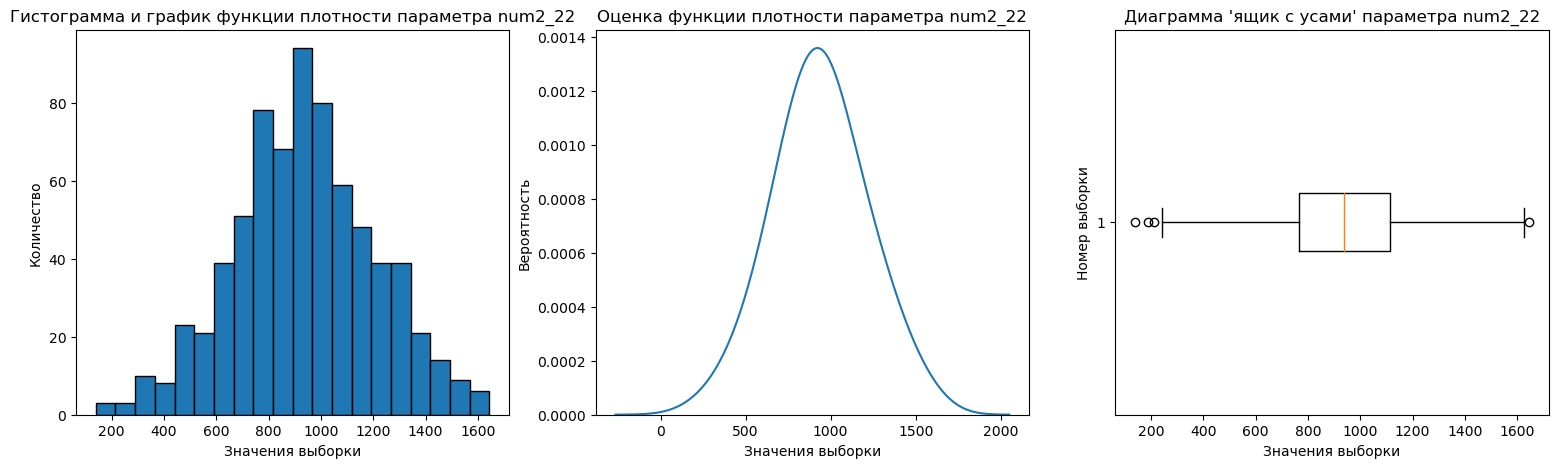

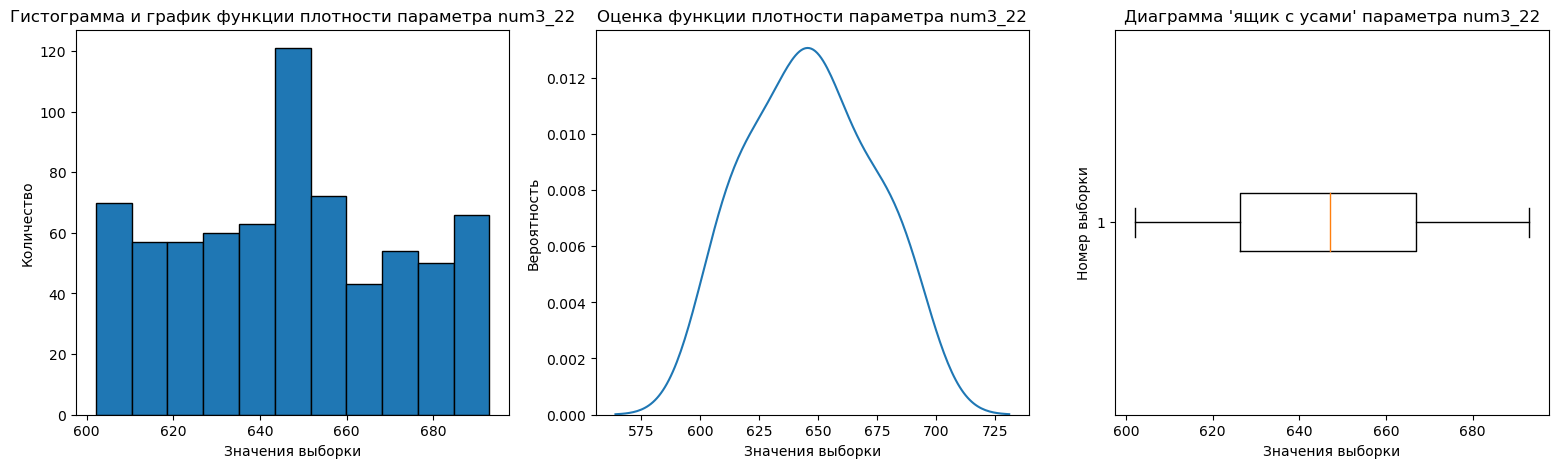

In [30]:
for column in quantitative_variables:
    build_histogram_density_diagram(dataframe[column],column)